# Simulating a Spiking Neural Network

@[Xiaoyu Chen](mailto:c-xy17@tsinghua.org.cn)

Spiking neural networks (SNN) are one of the most important tools to study brian dynamcis in computational neuroscience. They simulate the biological processes of information transmission in the brain, including the change of membrane potentials, neuronal firing, and synaptic transmission. In this section, we will illustrate how to build and simulate a SNN.

Before we start, the BrainPy package should be imported:

In [1]:
import brainpy as bp

bp.math.set_platform('cpu')

## Building an E-I balance network

Let's try to build a E-I balance network. The structure of a E-I balance network is as follows:

<center><img src="../_static/E_I_balance_network.png" width="400 px"></center>
<center>Illustration of an E-I Balance Network</center>
<br>

A E-I balance network is composed of two neuron groups and the synaptic connections between them. Specifically, they include:
1. a group of excitatory neurons (E),
2. a group of inhibitory neurons (I),
3. synaptic connections within the excitatory and inhibitory neuron groups, respectively, and 
4. the inter-connections between these two groups.

To construct the network, we need to define these components one by one. BrainPy provides plenty of handy built-in models for brain dynamic simulation. They are contained in ``brainpy.dyn``. Let's choose the simplest yet the most canonical neuron model, the Leaky Integrate-and-Fire (LIF) model, to build the excitatory and inhibitory neuron groups:

In [58]:
E = bp.dyn.LIF(3200, V_rest=-60., V_th=-50., V_reset=-60., tau=20., tau_ref=5., method='exp_auto')
I = bp.dyn.LIF(800, V_rest=-60., V_th=-50., V_reset=-60., tau=20., tau_ref=5., method='exp_auto')

E.V[:] = bp.math.random.randn(3200) * 2 - 60.
I.V[:] = bp.math.random.randn(800) * 2 - 60.

When defining the LIF neuron group, the parameters can be tuned according to users' need. The first parameter denotes the number of neurons. Here the ratio of excitatory and inhibitory neurons is set 4:1. ``V_rest`` denotes the resting potential, ``V_th`` denotes the firing threshold, ``V_reset`` denotes the reset value after firing, ``tau`` is the time constant, and ``tau_ref`` is the duration of the refractory period. ``method`` refers to the numerical integration method to be used in simulation. 

Then the synaptic connections between these two groups can be defined as follows:

In [59]:
E2E = bp.dyn.ExpCOBA(E, E, bp.conn.FixedProb(prob=0.02), E=0., g_max=0.6, tau=5., method='exp_auto')
E2I = bp.dyn.ExpCOBA(E, I, bp.conn.FixedProb(prob=0.02), E=0., g_max=0.6, tau=5., method='exp_auto')
I2E = bp.dyn.ExpCOBA(I, E, bp.conn.FixedProb(prob=0.02), E=-80., g_max=6.7, tau=10., method='exp_auto')
I2I = bp.dyn.ExpCOBA(I, I, bp.conn.FixedProb(prob=0.02), E=-80., g_max=6.7, tau=10., method='exp_auto')

Here we use the Expnential synapse model (``ExpCOBA``) to simulate synaptic connections. Among the parameters of the model, the first two denotes the pre- and post-synaptic neuron groups, respectively. The third one refers to the connection types. In this example, we use ``bp.conn.FixedProb``, which connects the presynaptic neurons to postsynaptic neurons with a given probability (detailed information is available in [Synaptic Connection](../tutorial_toolbox/synaptic_connections.ipynb)). The following three parameters describes the dynamic properties of the synapse, and the last one is the numerical integration method as that in the LIF model.

After defining all the components, they can be combined to form a network:

In [60]:
net = bp.dyn.Network(E2E, E2I, I2E, I2I, E=E, I=I)

In the definition, neurons and synapses are given to the network. The excitatory and inhibitory neuron groups (`E` and `I`) are passed with a name, for they will be specifically operated in the simulation (here they will be given with input currents).

We have successfully constructed an E-I balance network by using BrainPy's biult-in models. On the other hand, BrianPy also enables users to customize their own dynamic models such as neuron groups, synapses, and networks flexibly. In fact, ``brainpy.dyn.Network()`` is a simple example of customizing a network model. Please refer to [Dynamic Simulation](../tutorial_simulation/index.rst) for more information.

## Running a simulation

After build a SNN, we can use it for dynamic simulation. To run a simulation, we need first wrap the network model into a **runner**. Currently BrainPy provides ``DSRunner`` and ``ReportRunner`` in ``brainpy.dyn``, which will be expanded in the [Runners](../tutorial_simulation/runner.ipynb) tutorial. Here we use ``DSRunner`` as an example:

In [61]:
runner = bp.dyn.DSRunner(net,
                         monitors=['E.spike', 'I.spike'],
                         inputs=[('E.input', 20.), ('I.input', 20.)],
                         dt=0.1)

To make dynamic simulation more applicable and powerful, users can [**monitor**](../tutorial_toolbox/monitors.ipynb) variable trajectories and give [**inputs**](../tutorial_toolbox/inputs.ipynb) to target neuron groups. Here we monitor the ``spike`` variable in the ``E`` and ``I`` LIF model, which refers to the spking status of the neuron group, and give a constant input to both neuron groups. The time interval of numerical integration ``dt`` (with the default value of 0.1) can also be specified.

After creating the runner, we can run a simulation by calling the runner:

In [62]:
runner(100)

  0%|          | 0/1000 [00:00<?, ?it/s]

0.779956579208374

where the calling function receives the simulation time (usually in milliseconds) as the input and returns the time (seconds) spent on simulation. BrainPy achieves an extraordinary simulation speed with the assistance of just-in-time (JIT) compilation. Please refer to [Just-In-Time Compilation](../tutorial_math/compilation.ipynb) for more details.

The simulation results are stored as NumPy arrays in the monitors, and can be visualized easily:

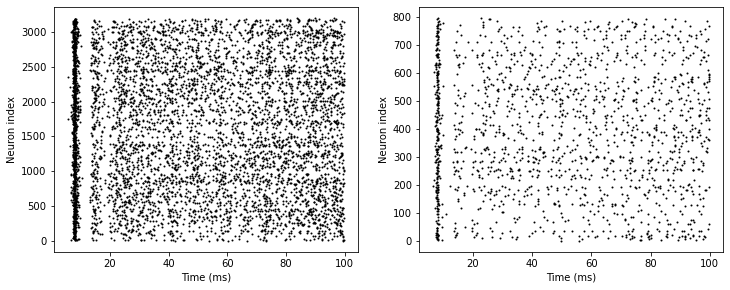

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4.5))

plt.subplot(121)
bp.visualize.raster_plot(runner.mon.ts, runner.mon['E.spike'], show=False)
plt.subplot(122)
bp.visualize.raster_plot(runner.mon.ts, runner.mon['I.spike'], show=True)

In the code above, ``brianpy.visualize`` contains some useful functions to visualize simulation results based on the ``matplotlib`` package. Since the simulation results are stored as NumPy arrays, users can directly use ``matplotlib`` for visualization.

## Building a decision making network